# Plot Downloaded Products

- We take the downloads from before
- We preview them
- We show that we can't just plot them easily
- Explain allowed ranges
- Generate a trimmed down version using *one* product

We continue with the files downloaded from `01a Download from Scihub.iypnb`.

<AxesSubplot:>

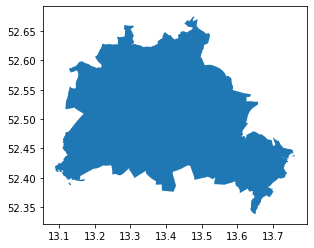

In [1]:
import geopandas as gpd
berlin = gpd.read_file('./input/berlin.geojson')
berlin.plot()

We know the product with the lowest cloud cover percentage from the previous notebook:

In [2]:
from pathlib import Path

raster_files = Path('input/raster/true_color_image')
product = list(raster_files.glob('S2B_MSIL2A_20200602T100559*.zip'))[0]
product

PosixPath('input/raster/true_color_image/S2B_MSIL2A_20200602T100559_N0214_R022_T33UUU_20200602T135324.zip')

## Previewing Downloaded Files

- **TODO:** Explain resolution and file structure
- **TODO:** Explain why we use the zip file directly

There is a helper that, given a resolution and the band name, returns the correct file paths for us to use with the `rasterio` library.
It contains code to deal with compressed or uncompressed products.

In [3]:
from sentinel_helpers import scihub_band_paths
??scihub_band_paths

Signature: scihub_band_paths(p, bands, resolution=None)
Source:   
def scihub_band_paths(p, bands, resolution=None):
    '''
    Given a zip file or folder at `p`, returns the paths inside p to the raster files containing
    information for the given bands. Because some bands are available in more than one
    resolution, this can be filtered by prodiding a third parameter (e.g. resolution='10m').
    
    `p` can be a string or a pathlib.Path.
    `bands` can be a list of bands or a single band.
   
    The returned paths are formatted in the zip scheme as per Apache Commons VFS if necessary
    and can be directly opened by rasterio.
    '''
    if type(bands) != list:
        # allow passing in a single band more easily
        bands = [bands]
    
    p = Path(p) # make sure we're dealing with a pathlib.Path
    if p.suffix == '.zip':
        # when dealing with zip files we have to read the filenames from the
        # archive first
        with zipfile.ZipFile(p) as f:
         

There is a pre-rendered True-Color Image ("TCI") that we can use to get a quick plot of the contents:

In [4]:
low_res = scihub_band_paths(product, 'TCI', '60m')[0]
low_res

'zip+file://input/raster/true_color_image/S2B_MSIL2A_20200602T100559_N0214_R022_T33UUU_20200602T135324.zip!/S2B_MSIL2A_20200602T100559_N0214_R022_T33UUU_20200602T135324.SAFE/GRANULE/L2A_T33UUU_A016922_20200602T101204/IMG_DATA/R60m/T33UUU_20200602T100559_TCI_60m.jp2'

In [5]:
import rasterio as r
import rasterio.plot as rplt

from matplotlib import pyplot as plt
%matplotlib inline

In [6]:
true_color = r.open(low_res)
tci = true_color.read()

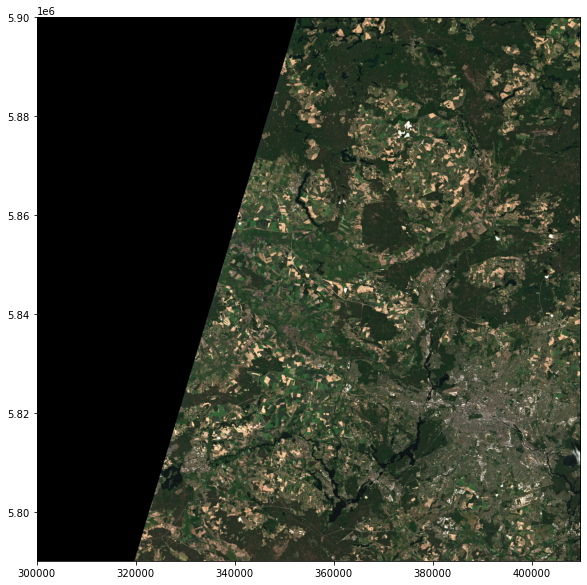

In [7]:
fig, (ax) = plt.subplots(1, 1, figsize=(10,10))
rplt.show(tci, transform=true_color.transform, ax=ax)
plt.show()

## Creating Your Own Composed Image

- We can't just plot images by combining the different bands
- The raster files contain values outside of the allowed range
- **TODO** Check resolution of plot before printing

In [8]:
import numpy as np
from sentinel_helpers import scihub_bgr_paths, scihub_normalize_range

In [16]:
b02, b03, b04 = scihub_bgr_paths(product, '60m')
b02, b03, b04

('zip+file://input/raster/true_color_image/S2B_MSIL2A_20200602T100559_N0214_R022_T33UUU_20200602T135324.zip!/S2B_MSIL2A_20200602T100559_N0214_R022_T33UUU_20200602T135324.SAFE/GRANULE/L2A_T33UUU_A016922_20200602T101204/IMG_DATA/R60m/T33UUU_20200602T100559_B02_60m.jp2',
 'zip+file://input/raster/true_color_image/S2B_MSIL2A_20200602T100559_N0214_R022_T33UUU_20200602T135324.zip!/S2B_MSIL2A_20200602T100559_N0214_R022_T33UUU_20200602T135324.SAFE/GRANULE/L2A_T33UUU_A016922_20200602T101204/IMG_DATA/R60m/T33UUU_20200602T100559_B03_60m.jp2',
 'zip+file://input/raster/true_color_image/S2B_MSIL2A_20200602T100559_N0214_R022_T33UUU_20200602T135324.zip!/S2B_MSIL2A_20200602T100559_N0214_R022_T33UUU_20200602T135324.SAFE/GRANULE/L2A_T33UUU_A016922_20200602T101204/IMG_DATA/R60m/T33UUU_20200602T100559_B04_60m.jp2')

- This is what happens when we plot naively
  - Left to right: pre-rendered `TCI`, middle: just plot it, right: clipped image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


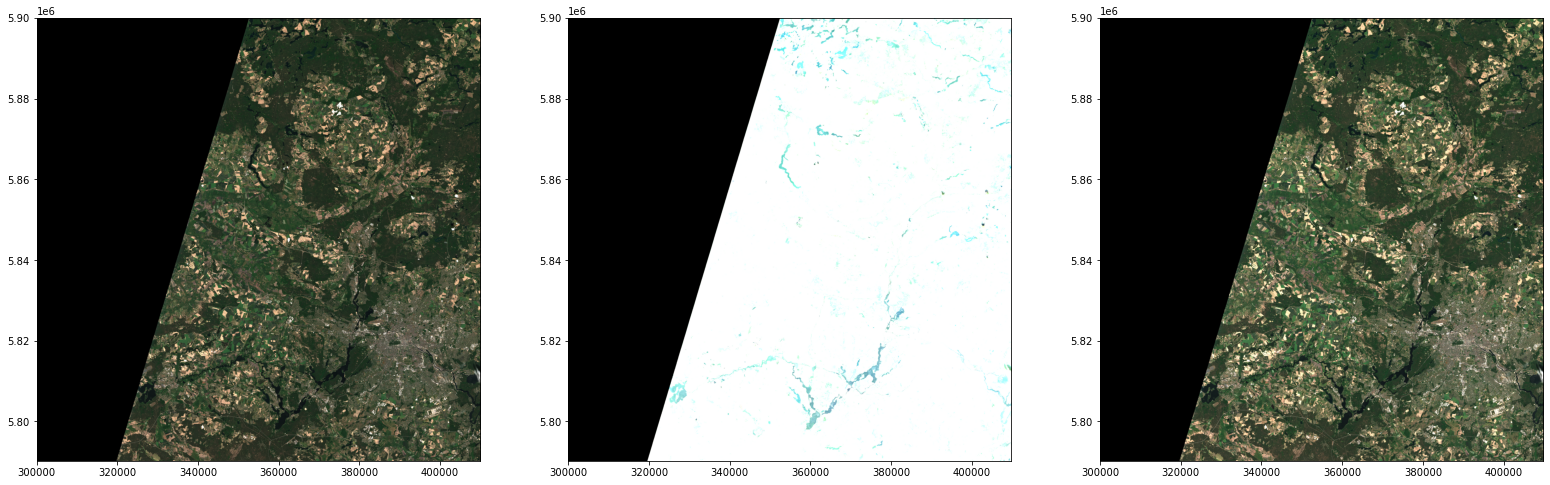

In [11]:
with r.open(b02) as blue, r.open(b03) as green, r.open(b04) as red:
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(27,9))
    transform = blue.transform
    
    rplt.show(tci, transform=transform, ax=ax1)
    rplt.show([red.read(1), green.read(1), blue.read(1)],
              transform=transform, ax=ax2)
    rplt.show([scihub_normalize_range(red.read(1)),
               scihub_normalize_range(green.read(1)),
               scihub_normalize_range(blue.read(1))],
              transform=transform, ax=ax3)
    
    plt.show()
    fig.savefig('berlin_true_color_image_naive_plot.png', dpi=300)

- **TODO** Compare histogram

## Hi-Resolution Plot

### Subsetting to the desired area

In [18]:
b02, b03, b04 = scihub_bgr_paths(product, '10m')
b02, b03, b04

('zip+file://input/raster/true_color_image/S2B_MSIL2A_20200602T100559_N0214_R022_T33UUU_20200602T135324.zip!/S2B_MSIL2A_20200602T100559_N0214_R022_T33UUU_20200602T135324.SAFE/GRANULE/L2A_T33UUU_A016922_20200602T101204/IMG_DATA/R10m/T33UUU_20200602T100559_B02_10m.jp2',
 'zip+file://input/raster/true_color_image/S2B_MSIL2A_20200602T100559_N0214_R022_T33UUU_20200602T135324.zip!/S2B_MSIL2A_20200602T100559_N0214_R022_T33UUU_20200602T135324.SAFE/GRANULE/L2A_T33UUU_A016922_20200602T101204/IMG_DATA/R10m/T33UUU_20200602T100559_B03_10m.jp2',
 'zip+file://input/raster/true_color_image/S2B_MSIL2A_20200602T100559_N0214_R022_T33UUU_20200602T135324.zip!/S2B_MSIL2A_20200602T100559_N0214_R022_T33UUU_20200602T135324.SAFE/GRANULE/L2A_T33UUU_A016922_20200602T101204/IMG_DATA/R10m/T33UUU_20200602T100559_B04_10m.jp2')

In [42]:
blue = r.open(b02)

- Make sure our area of interest and the raster files have the same coordinate reference system

In [43]:
from rasterio.clip import clip

ModuleNotFoundError: No module named 'rasterio.clip'

In [41]:
from shapely.geometry import box

bounds = berlin.to_crs(blue.crs).bounds.loc[0].values

In [60]:
from rasterio.windows import Window

- **TODO** Use mask instead?

In [66]:
# https://github.com/mapbox/rasterio/blob/d7b2dd3ae64c55978e265fa9230732e88b1dc9ae/rasterio/rio/clip.py
with r.open(b02) as src:
    out_window = src.window(*bounds).round_lengths(op='floor')
    out_window = bounds_window.intersection(
        Window(0, 0, src.width, src.height)
    )
    
    height = int(out_window.height)
    width = int(out_window.width)

    out_kwargs = src.profile
    out_kwargs.update({
        'height': height,
        'width': width,
        'transform': src.window_transform(out_window)})

    with r.open('/tmp/window.jp2', "w", **out_kwargs) as out:
        out.write(
            src.read(
                window=out_window,
                out_shape=(src.count, height, width),
                boundless=True,
            )
        )

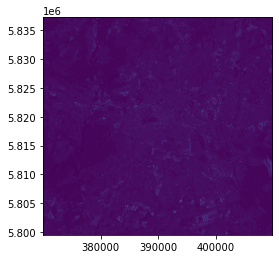

In [67]:
with r.open('/tmp/window.jp2') as src:
    rplt.show(src)

In [115]:
with r.open(b02) as blue, r.open(b03) as green, r.open(b04) as red:
    out_window = blue.window(*bounds).round_lengths(op='floor')
    out_window = bounds_window.intersection(
        Window(0, 0, blue.width, blue.height)
    )
    
    height = int(out_window.height)
    width = int(out_window.width)

    out_kwargs = blue.profile
    out_kwargs.update({
        'count': 3, # number of bands
        'height': height,
        'width': width,
        'transform': blue.window_transform(out_window),
        'driver': 'GTiff',
        'dtype': np.uint8
    })

    with r.open('/tmp/window.tif', "w", **out_kwargs) as out:
        src_bands = [red, green, blue]
        for idx, src in enumerate(src_bands, start=1):
            subset = scihub_normalize_range(src.read(
                1,
                window=out_window,
                out_shape=(1, height, width),
                boundless=True,
            ))
            out.write((subset * 255).astype(np.uint8), idx)

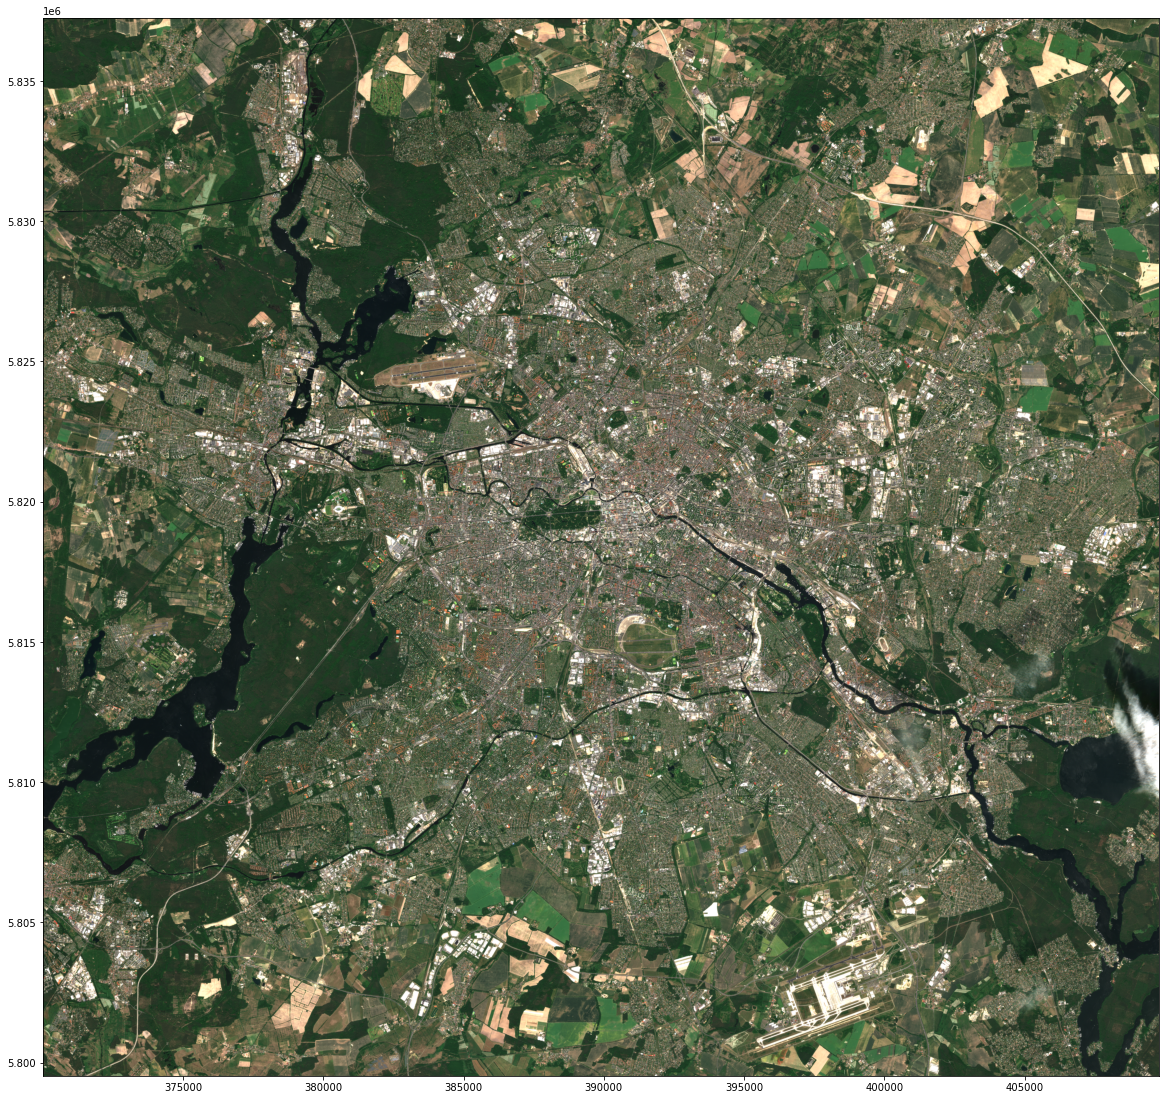

In [117]:
with r.open('/tmp/window.tif') as src:
    plt.figure(figsize=(20, 20))
    rplt.show(src)

- **TODO** Sentinel Hub plays around in another color space so colors closer match a viewer's perception